# Project Final Report
#### project-002-21  
**Group members**: Natalie Huang, Norah Bradley, Maliet Akuei, Zoe Van Montfort <br> 
**Student Numbers**: 93033579, 77637320, 22942288, 70537402
<br>
DSCI 100-002  

## Introduction

This project explores a real-world data science problem in collaboration with a computer science research group from UBC led by Dr. Frank Wood. The group is collecting data on player behaviour within a custom-designed Minecraft server, where players' actions are tracked as they interact with the game world. The aim is to better understand how people interact with video games using real-time behavioural data.

To support this research, this report investigates the broad question: Which kinds of players are most likely to contribute a large amount of data, and how can those players be targeted in recruitment efforts? Specifically, the analysis focuses on the question: **How does a player’s age influence the number of hours they play?** The objective is to assess whether age is a meaningful predictor of engagement, measured by total gameplay time, and to provide insight into recruitment strategies for highly engaged players.

This investigation uses the `players.csv` dataset, collected from a recorded Minecraft server, which includes 196 observations and 7 variables describing player characteristics:
1. `experience`: Player’s skill level (e.g., Beginner, Amateur, Veteran); character
  
2. `subscribe`: Whether the player is subscribed to the game’s newsletter; logical
  
3. `hashedEmail`: Anonymized player email (unique identifier); character  
  
4. `played_hours`: Total hours played, recorded to one decimal place; double  
  
5. `name`: Player’s chosen in-game username; character  
  
6. `gender`: Player's Self-identified gender; character  
  
7. `Age`: Player’s age in years; double

In addition to `players.csv`, the project includes a second dataset, `session.csv`, which contains 1,535 observations and 5 variables of individual player sessions:
1. `hashedEmail`: Registered email addresses of players; character

2. `start_time`: Date and time (in military time) when the players' sessions started; character

3. `end_time`: Date and time (in military time) when the players' sessions ended; character

4. `original_start_time`: Time when the players sessions started in numerical format; double

5. `original_end_time`: Time when the players sessions ended in numerical format; double


However, since this project focuses on player-level characteristics, only the `players.csv` dataset is used for analysis.

## Methods and Plans

The analysis will begin by splitting the players.csv dataset into training (75%) and testing (25%) sets. Using a larger training set increases the reliability of clustering results by providing more data for the model to identify meaningful patterns, thus allowing for more effective classification modelling.

Next, the training data will be scaled and centered. This step ensures that all variables contribute equally to distance-based calculations, which is essential for clustering methods like k-means that are sensitive to variable scale.

To determine the optimal number of clusters (k), several values of k will be tested by calculating the Total Within-Cluster Sum of Squares (WSS) for each. These values will then be plotted to produce an elbow plot, which helps identify the point where increasing k no longer significantly improves model performance. The “elbow” in the curve is used to select the most appropriate k value for clustering.

Once the optimal number of clusters is identified, k-means clustering will be applied to the scaled training data. This allows the model to group players based on similarities in their `Age` and `played_hours` values. By analyzing the resulting clusters, it will allow for the identification of which group of players contributes the most gameplay data and whether age appears to influence cluster membership. Visualizations will then be used to further interpret the patterns within each cluster and to assess how well clustering captured meaningful differences in player engagement.

In [1]:
# Load libraries
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(forcats)
library(repr)
library(GGally)

options(repr.matrix.max.rows = 10)

# source("cleanup.R")
set.seed(2000)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Load data
First, we begin by reading the `players.csv` file. 

In [2]:
# Load datasets
players_url <- "https://raw.githubusercontent.com/Norah-supercoder/dsci-100-project-individual/refs/heads/main/players.csv"
players <- read_csv(players_url)
players 

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


#### Wrangle and clean data
Next, the data was tidied by renaming the `hashedEmail` and Age columns to follow a consistent format, using lowercase letters and underscores to separate words. Here, any missing data or empty cells are omitted from the file as well. 

In [3]:
# Tidy data
players <- rename(players, 
                        hashed_email = hashedEmail, 
                        age = Age)

players <- na.omit(players)

#### Summary of data set
Next, to better understand the data and identify which types of players had the highest number of played hours, a scatter plot visualization was created. The variable experience was first transformed into a factor. Then, the mean played hours and mean age were calculated for each experience level to explore potential trends in player engagement across different skill levels.

In [4]:
# Wrangle data and find mean values
players_mean <- players |>
    group_by(experience)|>
    summarize(average_hours = mean(played_hours),
             average_age = mean(age), 
             count = n())|>
mutate(experience=as_factor(experience))

players

experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,0.0,Rhys,Male,20
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22


#### Visualization of data set

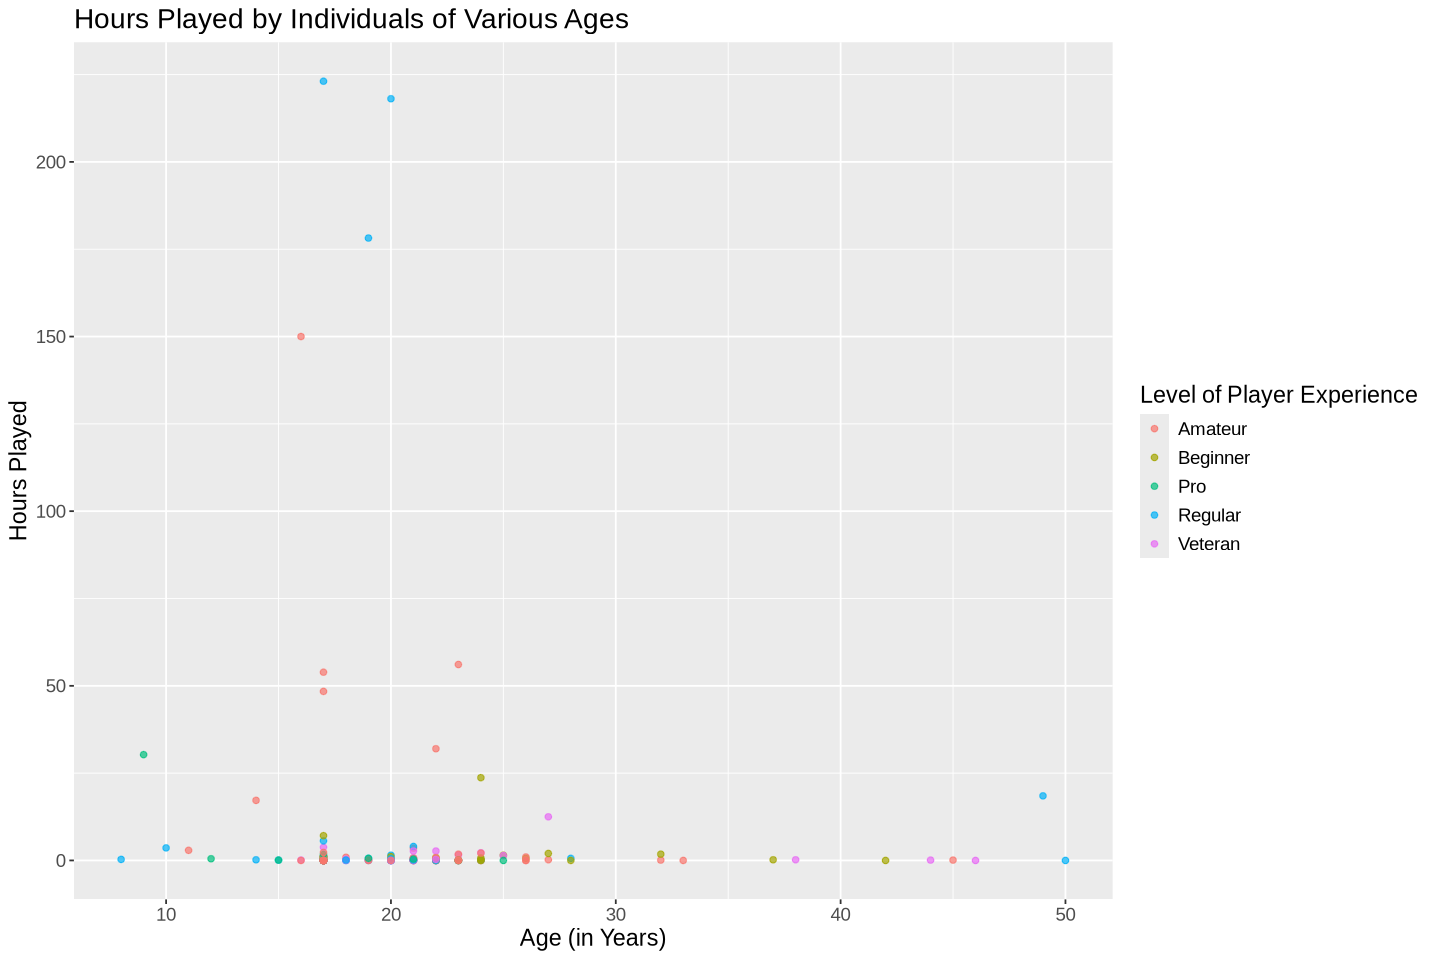

In [5]:
# Create scatterplot visualization
options(repr.plot.width = 12, repr.plot.height = 8)

players_time_plot <- ggplot(players, 
                            aes(x = age, 
                                y = played_hours, 
                                color = experience))+
        geom_point(alpha = 0.7) +
        labs(color = "Level of Player Experience", 
             x = "Age (in Years)", 
             y = "Hours Played", 
             title = "Hours Played by Individuals of Various Ages")+
        theme(text = element_text(size = 14))

players_time_plot 

**Figure 1:**  *This scatter plot shows the relationship between a player's age and their total hours played, categorized by their experience level.*

#### Data Analysis
This plot shows that `Amateur` and `Regular` players have the most played hours with an age of ~20. To begin the actual investigation, we began by splitting the data set into a 75% training set and a 25% testing set. 

In [6]:
# Create training and testing groups
players_split <- initial_split(players, prop = 0.75, strata = experience)  
players_train <- training(players_split)   
players_test <- testing(players_split)

players_train
players_test

experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17
Amateur,TRUE,3caa832978e0596779f4ee7c686c4592fb6de893925025d25bf26be9a8cd03f5,0.2,Thatcher,Male,22
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,TRUE,af6b2350478c6bd6af97c91c7eed1d121b82676d1d519ef5b6cfa16dd451fe27,0.0,Saif,Agender,20
Pro,FALSE,e1e5b1d36ab7680b6927fd3cb619c2b5373167750f90f7a21bf67b5d9b0fd73f,0.0,Jesse,Non-binary,17
Veteran,FALSE,a1e0438d568b9c05a93cadaf99969e4d44794d19dea31edd723cbc916f878c33,2.7,Jamie,Non-binary,21


experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,a175d4741dc84e6baf77901f6e8e0a06f54809a34e6b5211159bced346f7fb3e,48.4,Xander,Female,17
Amateur,FALSE,200db0417ee70863c7e2a0f214c737476fb86de5869d0b907a077d726357e687,0.1,Anastasia,Female,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,TRUE,6b1cdc07fcc1f7ea09509341fd245dd34fdba386f14a493e9107c18604baedc9,0.1,Finnian,Non-binary,17
Amateur,FALSE,93efabc9f7de58f44c457bac715cf8f9f44cd88cc574fc02624cac194d2f0ea5,2.1,Sebastián,Male,24
Regular,FALSE,8e98b6db2053af0bc0e62cd55bcea5a08f23986dec3d02ca520ea039517e6744,0.1,Sam,Male,18


Before moving any further, we also had to scale and center the data to ensure that the weight of different variables would not impact any future clustering. 

In [7]:
# Scale and center data
players_recipe <- recipe(~ played_hours + age, data = players) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

To determine the optimal number of clusters (k) for the k-means model, a tibble was first created containing values of k ranging from 1 to 10. This tibble was then used to tune those different k values and the corresponding Total Within-Cluster Sum of Squares was calculated. he WSS values were then plotted against the k values to produce an elbow plot, which helped identify the point where increasing k no longer substantially reduced the WSS. This point was used to select the most appropriate k for clustering

In [8]:
players_ks <- tibble(num_clusters = 1:10)

players_spec_tune <- k_means(num_clusters = tune()) |>
       set_engine("stats", nstart = 10)

players_tuning_stats <- workflow() |>
       add_recipe(players_recipe) |>
       add_model(players_spec_tune) |>
       tune_cluster(resamples = apparent(players), grid = players_ks) |>
       collect_metrics()

elbow_stats <- players_tuning_stats |>
       mutate(total_WSSD = mean) |>
       filter(.metric == "sse_within_total") |>
       select(num_clusters, total_WSSD)

elbow_stats

num_clusters,total_WSSD
<int>,<dbl>
1,386.00000
2,210.50205
3,86.11615
4,46.74326
5,36.32120
6,27.86122
7,20.39378
8,17.02723
9,13.33131


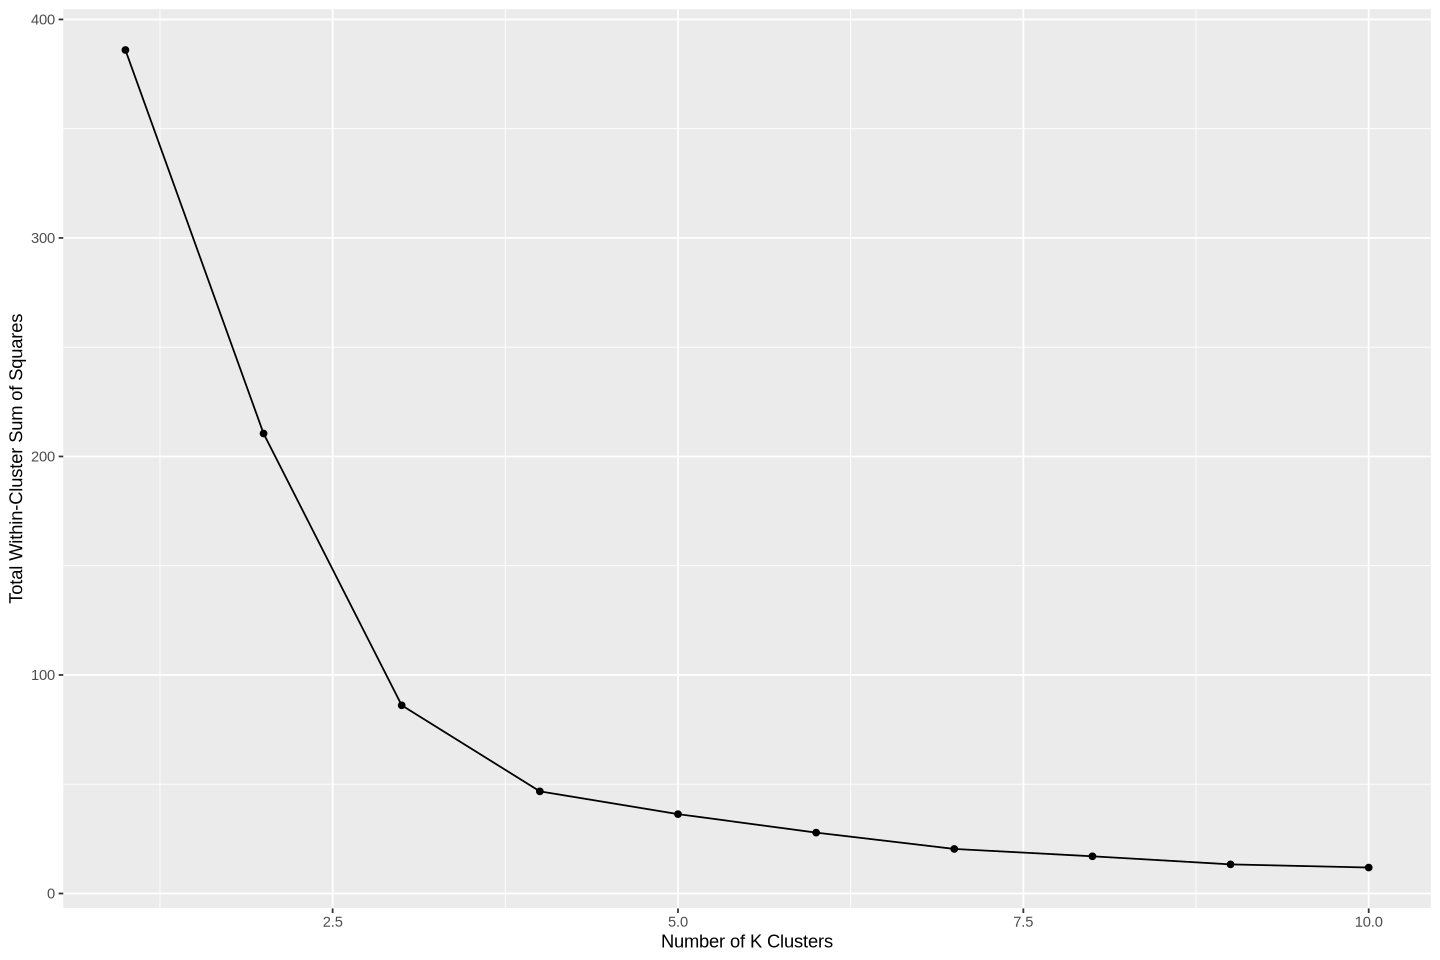

In [9]:
choose_players_k <- ggplot(elbow_stats, aes(x = num_clusters, y = total_WSSD))+
    geom_point()+
    geom_line()+
    labs(x = "Number of K Clusters", 
         y = "Total Within-Cluster Sum of Squares")

choose_players_k

**Figure 2: Elbow Plot for Determining Optimal Number of Clusters**  
*This plot displays the total within-cluster sum of squares for different values of K. The “elbow” occurs at K = 4, suggesting that 4 clusters best represent the data structure.*

From the elbow plot, the optimal number of clusters was determined to be 4, as the slope of the curve noticeably flattens at this point, indicating diminishing returns beyond k = 4. This point is recognized as the “elbow” of the plot.

Using this optimal value, the data was then clustered into 4 distinct groups. A scatter plot was created to visualize the clusters, with each one displayed in a different color to highlight group separation based on players’ age and hours played.

In [10]:
set.seed(2019) 
players_spec <- k_means(num_clusters = 4)|>
       set_engine("stats")

players_clustering <- workflow() |> 
    add_recipe(players_recipe) |> 
    add_model(players_spec) |> 
    fit(data = players)
players_clustering

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: k_means()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-means clustering with 4 clusters of sizes 111, 71, 4, 8

Cluster means:
  played_hours        age
2   -0.1453922 -0.5541221
3   -0.1273773  0.4631283
4    6.5424167 -0.4082193
1   -0.1234173  3.7822899

Clustering vector:
  [1] 1 1 1 2 2 1 1 2 1 2 2 1 2 2 1 2 1 1 1 1 1 1 1 1 2 2 1 2 2 1 2 2 1 2 2 1 2
 [38] 1 1 1 1 1 2 2 2 2 1 2 2 2 2 3 1 2 4 1 1 1 1 4 1 1 1 1 2 2 2 1 1 2 1 1 1 2
 [75] 3 2 2 1 2 2 1 1 4 2 1 2 2 1 1 2 3 1 1 1 2 1 1 1 1 1 1 1 2 2 2 1 2 2 1 1 2
[112] 2 1 1 1 2 1 1 4 2 1 2 2 1 1 4 2 2 1 1 2 2 1 1 1 2 1 1 1 1 1 1 1 1 2 1 2 4
[149] 1 1 1 1 1 1 1 1 2 3 2 2 1 1 1 2 2 2 1 1 1 2 2 1 4 1 1 1 2 1 1 2 2 1 2 1 1
[186] 4 1 1 1 1 1 2 1 1

Within cluster sum of

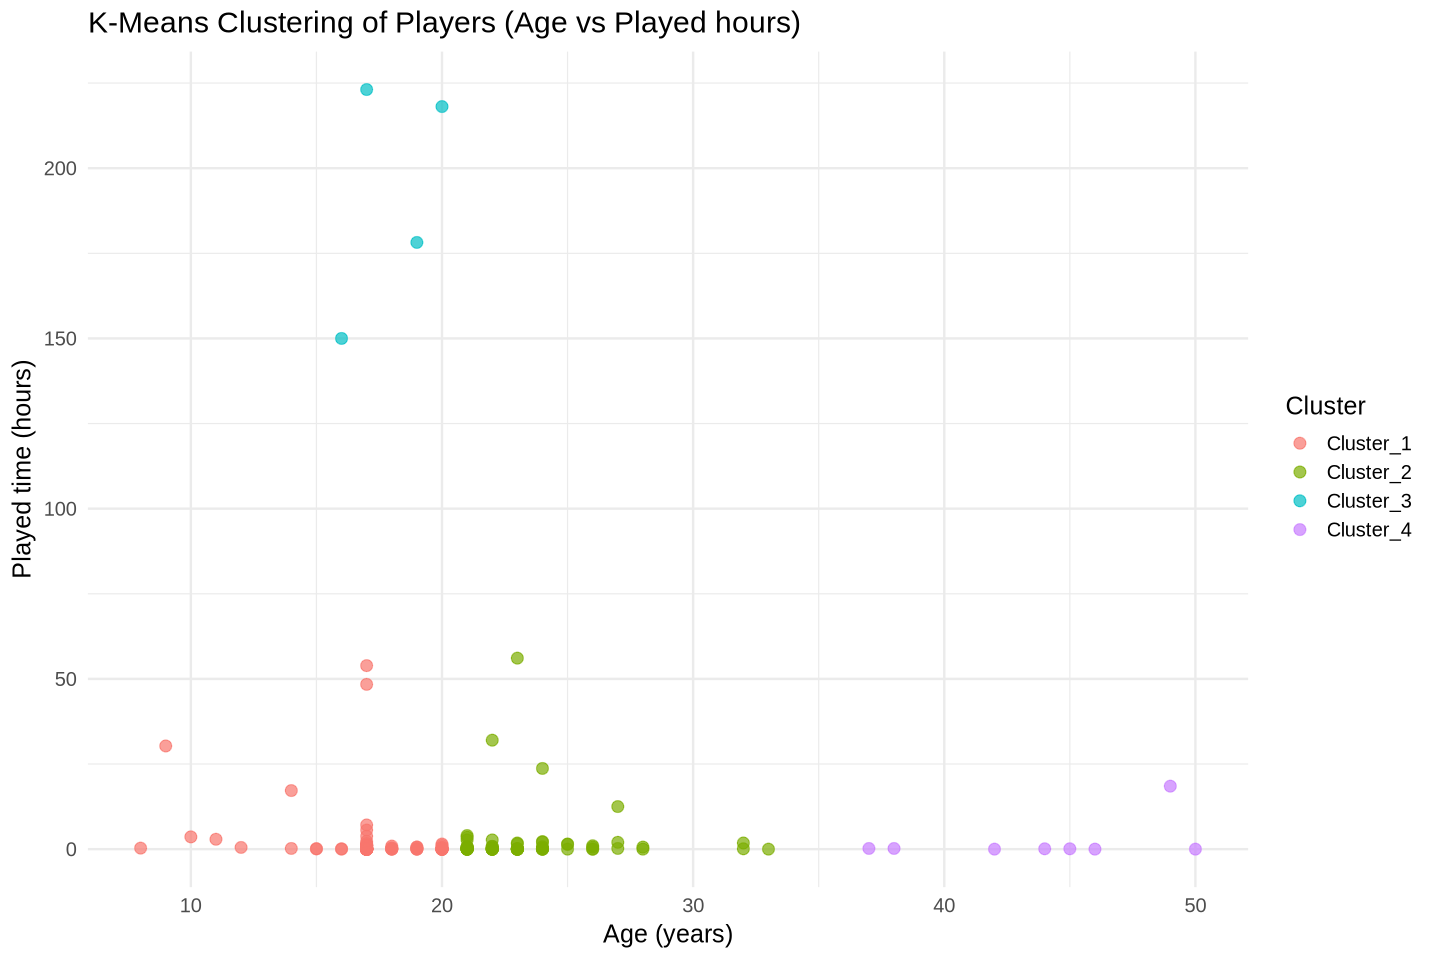

In [11]:
clustered_players <- augment(players_clustering, players)
players_clustering_plot <- ggplot(clustered_players, aes(x = age, y = played_hours, color = .pred_cluster)) +
    geom_point(alpha = 0.7, size = 3) +  
    labs(
        title = "K-Means Clustering of Players (Age vs Played hours)",
        x = "Age (years)",
        y = "Played time (hours)",
        color = "Cluster"
    ) +
    theme_minimal(base_size = 15) 
players_clustering_plot

**Figure 3:**  *This scatter plot displays player clusters formed using age and played hours, with each color representing a distinct cluster. The clustering reveals distinct player groups, with one group (cluster 3 ) notably having high playtime concentrated among younger players.*

## Discussion


### Summary
The question explored in this analysis was: **How does a player’s age influence the number of hours they play?** To answer this, both exploratory visualizations and a classification model were used to assess patterns in the players.csv dataset, focusing on the `Age` and `played_hours` variables. These two variables were selected to examine whether age could serve as a meaningful predictor of gameplay engagement.

The analysis began with an initial visualization. A scatter plot was made (**Figure 1**) showing age against number of hours played. It revealed that players with the highest recorded playtime, reaching up to approximately 200 hours, were generally around 20 years old, suggesting a possible concentration of highly engaged players in that age range. In addition, there appeared to be a relationship between experience level and playtime, with amateur and regular players contributing the most hours. Although experience level was not the focus of this analysis, the overlap between players around age 20 and those with lower experience levels suggests that gaming companies could consider targeting not just younger players, but also those who are newer to gaming, as they may represent a group with high engagement potential.

Since a relationship was observed between age and played hours, a classification model using clustering was applied to further explore whether age can predict gameplay time. Clustering was used to simplify the dataset, making it easier to model by grouping similar observations. This simplification can help the model detect natural patterns more effectively and improve prediction accuracy. However, the optimal number of clusters was not immediately obvious. To determine this, the dataset was wrangled, and a within-cluster sum of squares (elbow) plot was created (**Figure 2**), comparing the total variance within clusters across different values of k. Based on this visualization, four clusters were selected, as the curve showed a noticeable decrease in slope at k = 4, suggesting that adding more clusters beyond this point yielded diminishing returns.

After creating the workflow, a scatter plot was generated (**Figure 3**) to visualize the relationship between age and number of hours played. The plot revealed that players around 20 years old, or slightly younger, recorded the highest number of gameplay hours, reaching approximately 200 hours. These players were grouped in the third of four clusters, which contained only four observations. While the visualization suggests a pattern between age and playtime, the small size of this cluster limits the model’s ability to make reliable predictions based on age alone.

The other three clusters, with sizes of 111, 71, and 8 observations, did not display any clear, strong relationship between age and played hours. A weak relationship was observed in which players aged 15 to 25 tended to play more than others. However, this trend is inconsistent, as many players within that same age range also played only 0–5 hours, which is where the majority of all observations fall.

### Conclusion and Comparison to Expectations
As a result, the model does not support any strong conclusions about the predictive power of age on gameplay time. Although players around age 20 may be slightly more likely to play more hours, many also fall into the average playtime range, suggesting that age is not a reliable standalone predictor. Intitally, the expected result of this analysis was to find a strong relationship where the age of a player could be used to predict the amount of time played. However, since only a weak relationship was found, this analysis did not meet the expectations we hoped to see from the analysis question, seeing as the classification modeling could not reliably be used to predict the number of hours played based on a player's age. 

### Impact of Findings
Although the relationship between age and number of hours played was weak, the findings still offer valuable insight. The data suggest that while players around age 20 may be more likely to contribute high gameplay hours, this is not consistent across all individuals in that age group. This means that targeting recruitment solely based on age would not be an effective strategy. However, recognizing that some less experienced players (such as amateurs and regulars) also contribute high gameplay time could guide recruitment efforts more effectively. These insights may help game developers or researchers better allocate resources, such as marketing campaigns or server capacity, by focusing on engagement-related characteristics beyond just age.

### Future Research Questions
The results open up several future research directions. Since age alone was not a strong predictor of engagement, it would be useful to explore how other variables, such as experience level, subscription status, or session frequency, relate to gameplay time. Additionally, a more in-depth analysis of the `session.csv` dataset, looking at patterns in session length, time of day, or frequency, could provide a more dynamic picture of player behavior over time. Future questions might include:

- Do subscribed players engage more consistently or for longer sessions?
- Is there a relationship between the time of day players log in and their total gameplay hours?
- How does a player’s experience level change over time, and does this influence engagement?

Investigating these questions could lead to more comprehensive models for predicting player behavior and supporting data-driven recruitment and resource planning.


In [12]:
source("cleanup.R")

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection
